# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Integration

In [3]:
df = pd.read_excel('/content/drive/MyDrive/Main_Data.xlsx', sheet_name=None)
df

{'2018':                DateTime         RH    Temp        Load
 0      01-01-2018 00:00  80.423000  18.160  174.542804
 1      01-01-2018 00:15  81.471000  18.064  175.981604
 2      01-01-2018 00:30  82.675000  17.927  178.636804
 3      01-01-2018 00:45  84.552000  17.745  180.045604
 4      01-01-2018 01:00  86.663000  17.751  182.254000
 ...                 ...        ...     ...         ...
 35035  31-12-2018 22:45  63.469773  17.647  181.566544
 35036  31-12-2018 23:00  61.612709  17.761  181.542448
 35037  31-12-2018 23:15  61.666345  17.689  181.600600
 35038  31-12-2018 23:30  60.732709  17.818  183.150424
 35039  31-12-2018 23:45  60.940891  17.827  183.731516
 
 [35040 rows x 4 columns],
 '2019':                DateTime          RH    Temp        Load
 0      01-01-2019 00:00   62.573618  17.529  183.656656
 1      01-01-2019 00:15   62.385228  17.504  183.735260
 2      01-01-2019 00:30   62.105566  17.469  186.280288
 3      01-01-2019 00:45   61.317384  17.527  184.08100

In [4]:
df_all = pd.concat(df.values(), ignore_index=True)
df_all.shape

(105216, 4)

# Data Cleaning

In [5]:
df_all = df_all.set_index('DateTime')

In [6]:
df_temp = df_all.drop(['Load', 'RH'], axis=1)

In [7]:
df_temp.head()

,Temp
DateTime,
01-01-2018 00:00,18.160
01-01-2018 00:15,18.064
01-01-2018 00:30,17.927
01-01-2018 00:45,17.745
01-01-2018 01:00,17.751


# EDA

<Axes: xlabel='DateTime'>

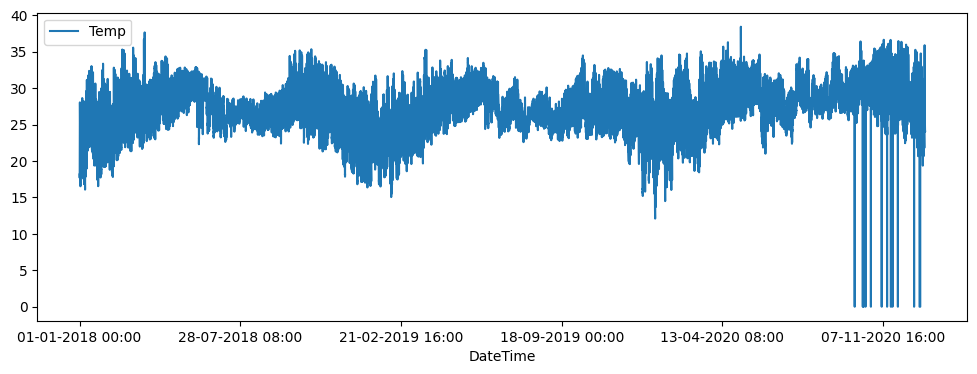

In [8]:
df_temp.plot(figsize=(12, 4))

In [9]:
len(df_temp)

105216

In [10]:
np_temp = df_temp.to_numpy()
np_temp

array([[18.16 ],
       [18.064],
       [17.927],
       ...,
       [24.   ],
       [24.03 ],
       [24.03 ]])

In [11]:
np_temp.shape

(105216, 1)

In [12]:
np_temp.dtype

dtype('float64')

# Scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
np_temp_scaled = scaler.fit_transform(np_temp)

In [14]:
np_temp_scaled.shape

(105216, 1)

In [16]:
np_temp_scaled = np_temp_scaled.astype('float32')
np_temp_scaled.dtype

dtype('float32')

# Data Preparation

In [17]:
def prepare_data(np_temp_scaled, n_input):
  X, y = [], []
  for i in range(len(np_temp_scaled)-n_input):
    window = i + n_input
    step = 192 + window
    if window>len(np_temp_scaled)-192:
      break
    else:
      seq_x, seq_y = np_temp_scaled[i:window], np_temp_scaled[window:step]
      X.append(seq_x)
      y.append(seq_y)
  return np.array(X), np.array(y)

In [18]:
n_input = 672
n_features = 1
X, y = prepare_data(np_temp_scaled, n_input)

In [19]:
X.dtype, y.dtype

(dtype('float32'), dtype('float32'))

In [20]:
X.shape, y.shape

((104353, 672, 1), (104353, 192, 1))

# Data Splitting

In [21]:
split_index = int(0.80 * len(X))  # 80% for training, 20% for testing
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

In [22]:
X_train.shape, y_train.shape

((83482, 672, 1), (83482, 192, 1))

In [23]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1])
y_train.shape

(83482, 192)

# Optuna

In [24]:
# import optuna

# def create_model(trial):

#   # Create the LSTM model
#   model = Sequential()
#   model.add(LSTM(units=(trial.suggest_int('lstm_1_units', y_train.shape[1], X_train.shape[1])), activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#   # model.add(LSTM(units=(trial.suggest_int('lstm_2_units', y_train.shape[1], X_train.shape[1])), activation='tanh', return_sequences=True))
#   model.add(LSTM(units=(trial.suggest_int('lstm_3_units', y_train.shape[1], X_train.shape[1])), activation='tanh'))
#   model.add(Dense(y_train.shape[1]))

#   # Compile the model
#   optimizer_name = trial.suggest_categorical("optimizer", ["adam", "SGD", "RMSprop", "Adadelta"])
#   model.compile(optimizer=optimizer_name, loss="mse")
#   return model

# def objective(trial):
#   model = create_model(trial)
#   epochs = trial.suggest_int("epochs", 5, 50, step=5, log=False)
#   batchsize = trial.suggest_int("batchsize", 50, 100, step=5, log=False)

#   # Train the model
#   model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs)

#   # Evaluate the model
#   scores = model.evaluate(X_val, y_val, verbose=0)
#   return scores[1]

# study = optuna.create_study()
# study.optimize(objective, n_trials=5)

# print(study.best_params)

# Model Building

In [25]:
model = Sequential()
model.add(LSTM(256, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(192))
model.compile(optimizer='adam', loss='mse')
model.summary()
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 672, 256)          264192    
                                                                 
 lstm_1 (LSTM)               (None, 672, 128)          197120    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 192)               12480     
                                                                 
Total params: 523,200
Trainable params: 523,200
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2088/2088 [==============================] - 177s 80ms/step - loss: 0.0089 - val_loss: 0.0114
Epoch 2/15
2088/2088 [==============================] - 166s 79ms/step - loss

# Training Loss v/s Validation Loss

In [26]:
loss = model.evaluate(X_val, y_val)
print("Test loss:", loss)

653/653 [==============================] - 21s 32ms/step - loss: 0.0077
Test loss: 0.007678849622607231


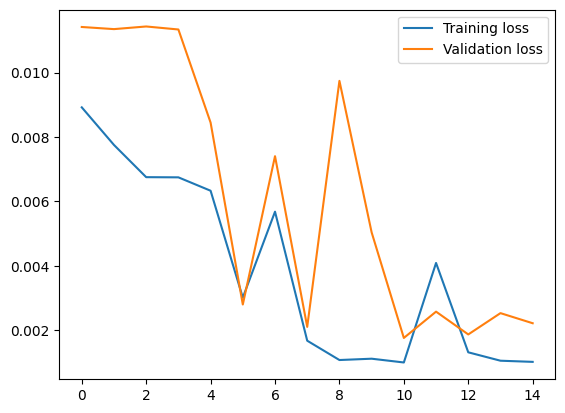

In [27]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

# Model Save

In [28]:
model.save('/content/drive/MyDrive/IMD-TP Load Forecast/LSTM/Temp_181920_v1.h5')

# Predictions

In [29]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/IMD-TP Load Forecast/LSTM/Temp_181920_v1.h5')
pred = model.predict(X_val)
pred

653/653 [==============================] - 21s 30ms/step


array([[0.73484963, 0.73175365, 0.730166  , ..., 0.73342633, 0.7311566 ,
        0.7273067 ],
       [0.7325857 , 0.7296701 , 0.7283043 , ..., 0.73048824, 0.72841996,
        0.7246514 ],
       [0.7308877 , 0.7281248 , 0.7269444 , ..., 0.7280209 , 0.7261524 ,
        0.7225125 ],
       ...,
       [0.5228077 , 0.5243591 , 0.52628577, ..., 0.53821975, 0.5363811 ,
        0.5332863 ],
       [0.52328014, 0.52598286, 0.5292268 , ..., 0.53530735, 0.53427356,
        0.5324462 ],
       [0.5241618 , 0.52809215, 0.53273606, ..., 0.5324597 , 0.532331  ,
        0.5319744 ]], dtype=float32)

# Performance Evaluation

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import pearsonr

def perf_eval(y_val, pred):
  rmse = np.sqrt(mean_squared_error(y_val, pred))
  kpcc = pearsonr(pred.flatten(), y_val.flatten())
  print(f'RMSE: {rmse}\nKPCC: {kpcc}')

In [31]:
perf_eval(y_val, pred)

RMSE: 0.08762901276350021
KPCC: PearsonRResult(statistic=0.5751383396930368, pvalue=0.0)


# Final Output

In [32]:
final_pred = scaler.inverse_transform(pred) #Inverse Scaling
final_pred

array([[28.24762 , 28.12861 , 28.067581, ..., 28.192907, 28.10566 ,
        27.95767 ],
       [28.160595, 28.04852 , 27.996017, ..., 28.079967, 28.000463,
        27.8556  ],
       [28.095324, 27.989117, 27.943743, ..., 27.985125, 27.9133  ,
        27.77338 ],
       ...,
       [20.09673 , 20.156364, 20.230425, ..., 20.689167, 20.61849 ,
        20.499525],
       [20.11489 , 20.21878 , 20.343477, ..., 20.577215, 20.537476,
        20.467232],
       [20.14878 , 20.299862, 20.478374, ..., 20.46775 , 20.462803,
        20.449095]], dtype=float32)

In [33]:
day1 = final_pred[:96]
day2 = final_pred[96:192]